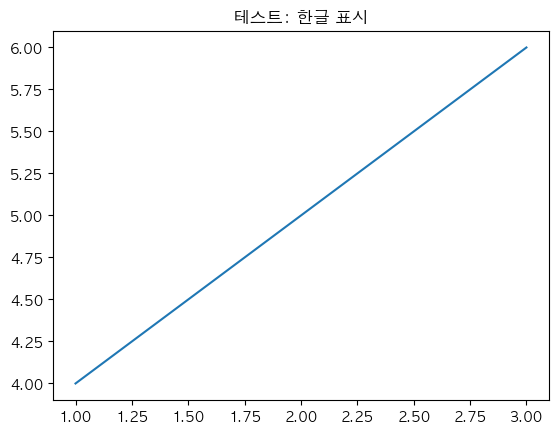

In [3]:
import pandas as pd
# from pandasai import SmartDataframe
# from pandasai.llm.openai import OpenAI

import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime as dt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

import statsmodels
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# MacOS에서 한글 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# 테스트 그래프
plt.title('테스트: 한글 표시')
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()
pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


In [4]:
import warnings
warnings.filterwarnings(action='ignore')

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

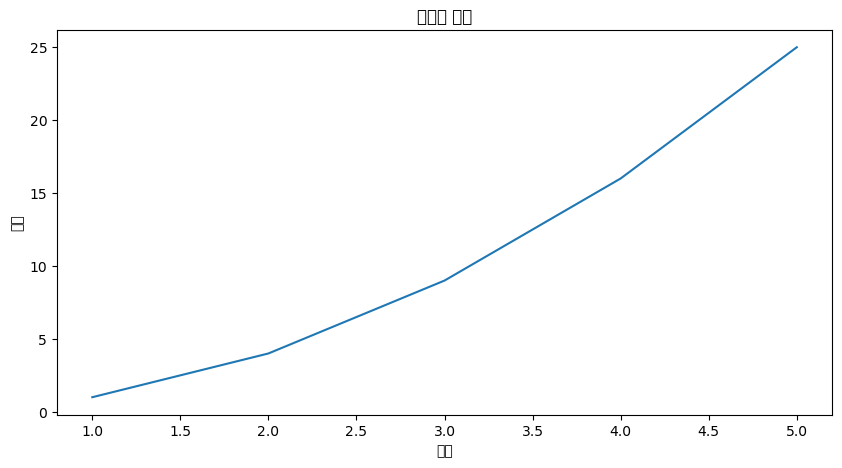

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 직접 지정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕의 경로
font_prop = fm.FontProperties(fname=font_path, size=12)

# 전역 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 테스트 차트
plt.figure(figsize=(10, 5))
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
plt.title('테스트 차트')
plt.xlabel('시간')
plt.ylabel('거리')
plt.show()


In [8]:
df = pd.read_csv('../result/result_0403_0509.csv')
# df = pd.read_excel('../result/result_0403_0509.xlsx',engine='openpyxl')
df['orderDate'] = pd.to_datetime(df['orderDate'],format='%Y%m%d')
df['click_time'] = df['subParam'].str.split('_').str.get(1)
df['subParam'] = df['subParam'].str.split('_').str.get(0)

In [10]:
df.subParam.nunique()

26905

## 분석 개요
1. 구매 범위가 너무 넓음. 아웃라이어를 초 VIP 구간으로 넣고, 나머지 평균을 구간화 하기
2. 유저 클릭 시간대 분포와 매출간의 상관성과 분포 보기
3. 유저 아이디 <> MMP 행동 매칭해서, 회귀분석
4. 재방문과 재구매와의 상관관계 보고, uplift 확인하기

## 아웃라이어 처리

In [5]:
# 시간 분포를 위한 로데이터 복제

td = df.query('click_time.notna()')

In [6]:
# 집계 및 아웃라이어 처리
df = df[(df['subParam'].notna()) & (df['subParam']!="0")]
df = df.query("subParam.notna()").groupby('subParam').agg({'total_gmv':'sum','total_commission':'sum','total_quantity':'sum','orderDate':'count'}).reset_index()
df = df[df['total_gmv']>0]

df['zscore'] = ss.zscore(df['total_gmv'])

# zscore > 3 이 일반적이지만, 1로 축소하여 컷. 5% 아웃라이어, 95% 대부분 모수
df['outlier'] = df['zscore'].abs() > 1
print('outlier : ', len(df.query('outlier == True')))
print('outlier ratio : ', len(df.query('outlier == True')) / len(df) )

tt = df.query('outlier == False')
ss = df.query('outlier == True')

outlier :  1413
outlier ratio :  0.054387990762124715


In [7]:
len(df)

25980

In [64]:
normal = tt.subParam.unique().tolist()
outlier = ss.subParam.unique().tolist()

In [18]:
ss.groupby('subParam')[['total_gmv']].sum().sort_values(by='total_gmv',ascending=True)

,total_gmv
subParam,
bc1def32-7451-413b-ae4e-2bd1c24feed7,128520.0
59ae9940-78b6-4767-b6e4-dc8b620b8684,128550.0
25dd202b-1178-41c7-9e95-3bde09950fbf,128580.0
c6dd75c0-9119-4267-a745-c4ddf6189dc9,128610.0
7e5af6bf-5d74-40d5-91a1-81248783b377,128620.0
...,...
27cd91e3-3028-41ef-9b29-203b86a58f1f,2436880.0
4c9a4976-5ca3-44eb-8d25-b18158731e54,2516900.0
95748e3a-78bb-4fa6-8699-b6158ce2de35,2599000.0


In [16]:
tt.query("subParam.isin(@normal)").groupby('subParam')[['total_gmv']].sum().sort_values(by='total_gmv',ascending=True)

,total_gmv
subParam,
efd1091f-a242-45b6-92e6-5ed2fca2e39e,2.0
6b0bb566-f284-418c-b002-574f9850a0b9,60.0
6784f8fd-ff99-4f7f-8329-2c4fa4c24e7d,100.0
327a6b9b-f8b7-46d7-a649-e92cb76c0854,100.0
afdf81d0-7d9e-4280-bfb7-97429b750d12,200.0
...,...
619725da-6bbe-4e0b-976b-06ef837ec731,128400.0
a7cb3731-5d81-4bdb-b57a-261f409a05a4,128400.0
07e98e96-15c6-4611-8f0c-8010b8230013,128440.0


### 시간 매출 분포

In [19]:

# 유저 아이디가 있는 아웃라이어/정상 유저들로 필터링

tt_tmp = td.query("subParam.isin(@normal)")
ss_tmp = td.query("subParam.isin(@outlier)")

tt_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21735 entries, 51567 to 80217
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         21735 non-null  int64         
 1   orderDate          21735 non-null  datetime64[ns]
 2   trackingCode       21735 non-null  object        
 3   subId              21735 non-null  object        
 4   subParam           21735 non-null  object        
 5   addtag             21735 non-null  int64         
 6   ctag               21735 non-null  object        
 7   orderId            21735 non-null  int64         
 8   productId          21735 non-null  int64         
 9   productName        21735 non-null  object        
 10  quantity           21735 non-null  int64         
 11  gmv                21735 non-null  float64       
 12  commissionRate     21735 non-null  float64       
 13  commission         21735 non-null  float64       
 14  date   

In [20]:
def get_date(df):
    df['hour_range'] = pd.to_datetime( df['click_time']).dt.floor('H')
    df['hour_range'] = df.hour_range.dt.strftime('%H')

    weekday_list = ['월','화','수','목','금','토','일']

    df['day'] = pd.to_datetime( df['click_time']).dt.weekday
    df['day'] = df.apply(lambda x : weekday_list[x['day']],axis=1)
    
    return df

normal_1 = get_date(tt_tmp)
outlier_1 = get_date(ss_tmp)

C:\Users\Owner\AppData\Local\Temp\ipykernel_25424\782682358.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour_range'] = pd.to_datetime( df['click_time']).dt.floor('H')
C:\Users\Owner\AppData\Local\Temp\ipykernel_25424\782682358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_range'] = pd.to_datetime( df['click_time']).dt.floor('H')
C:\Users\Owner\AppData\Local\Temp\ipykernel_25424\782682358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

그룹바이를 안해서 차트가 이상함. 다시 그룹바이하기

In [21]:
def gropupping(key,value):
    normal_1.groupby([key,'subParam'])[[value]].sum()


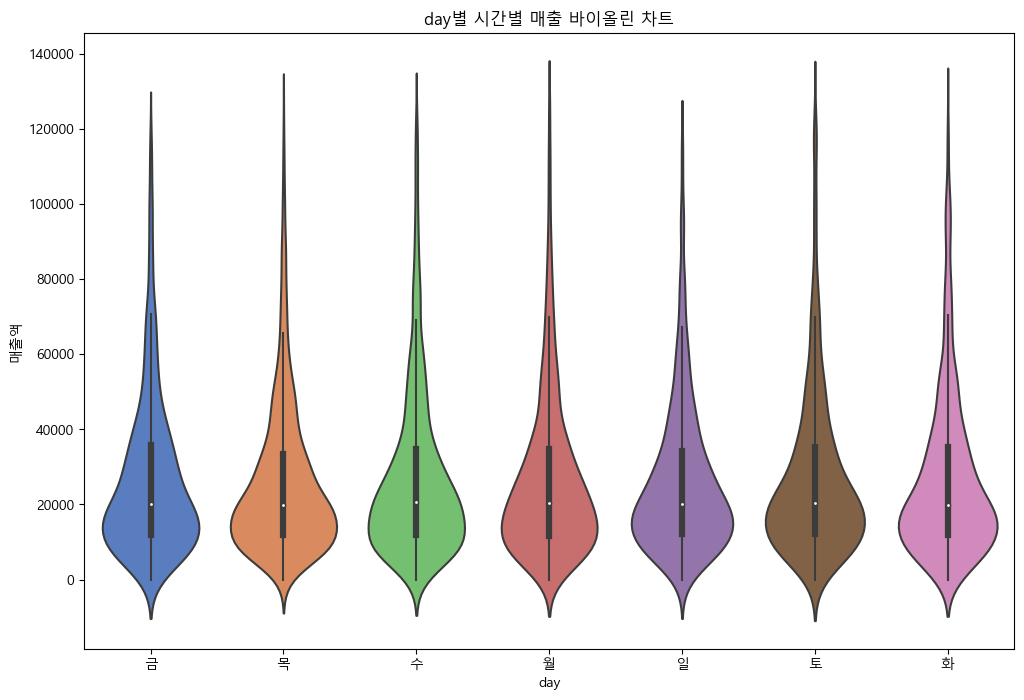

In [22]:
def get_chart_violin(df):
    # 바이올린 차트 그리
    df = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()

    plt.figure(figsize=(12, 8))
    sns.violinplot(x='day', y='total_gmv',  data=df, palette='muted', split=True)
    plt.title('day별 시간별 매출 바이올린 차트')
    plt.xlabel('day')
    plt.ylabel('매출액')
    plt.show()
    
get_chart_violin(normal_1)

In [ ]:
normal_1.columns

Index(['Unnamed: 0', 'orderDate', 'trackingCode', 'subId', 'subParam',
       'addtag', 'ctag', 'orderId', 'productId', 'productName', 'quantity',
       'gmv', 'commissionRate', 'commission', 'date', 'refund_quantity',
       'refund_gmv', 'refund_commission', 'total_gmv', 'total_commission',
       'total_quantity', 'click_time', 'hour_range', 'day'],
      dtype='object')

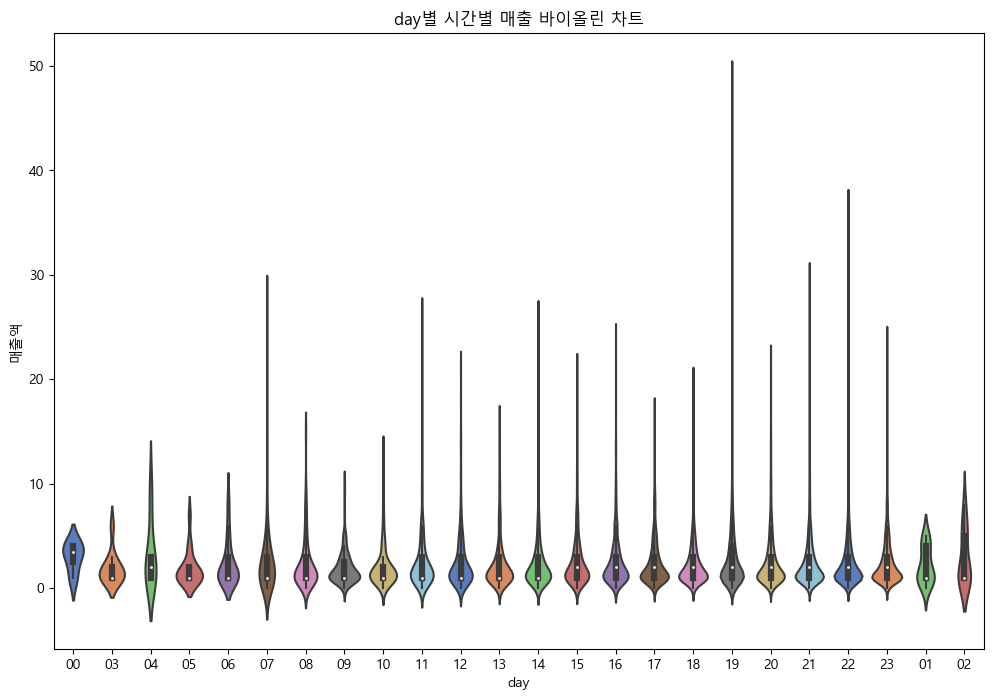

In [ ]:
def get_chart_violin(df):
    # 바이올린 차트 그리
    df = normal_1.groupby(['day','hour_range','subParam'])[['total_quantity']].sum().reset_index()

    plt.figure(figsize=(12, 8))
    sns.violinplot(x='hour_range', y='total_quantity',  data=df, palette='muted', split=True)
    plt.title('day별 시간별 매출 바이올린 차트')
    plt.xlabel('day')
    plt.ylabel('매출액')
    plt.show()
    
get_chart_violin(normal_1)

<Axes: xlabel='hour_range', ylabel='total_quantity'>

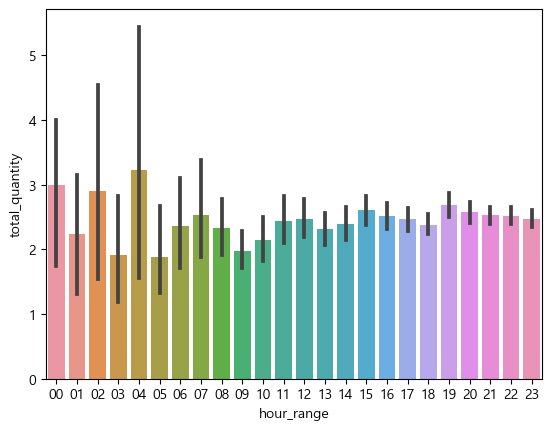

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_quantity']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_quantity')

<Axes: xlabel='hour_range', ylabel='total_gmv'>

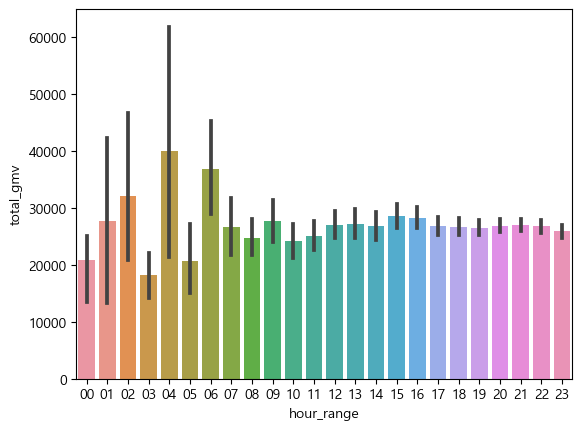

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_gmv')

<Axes: xlabel='hour_range', ylabel='total_gmv'>

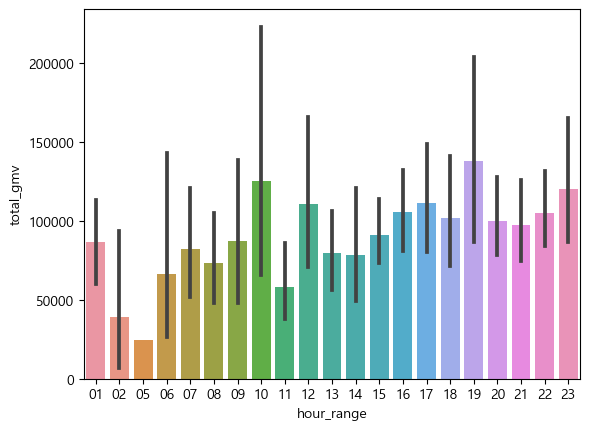

In [ ]:
kde = outlier_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_gmv')

<Axes: xlabel='day', ylabel='total_gmv'>

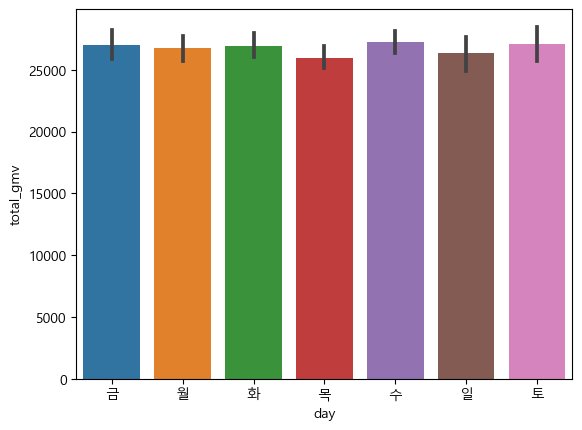

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='day',y='total_gmv')

<Axes: xlabel='day', ylabel='total_gmv'>

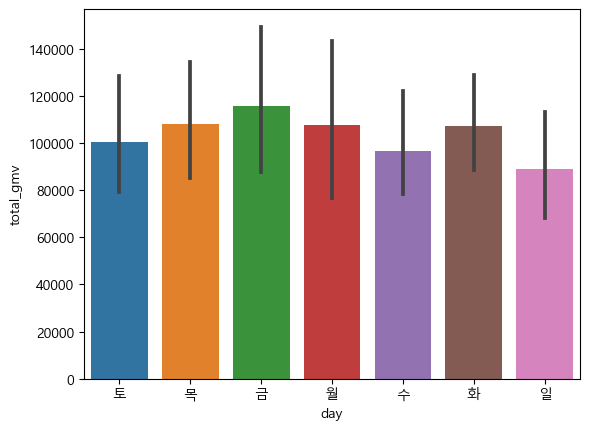

In [ ]:
kde = outlier_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='day',y='total_gmv')

### 구간화

In [ ]:
tt.total_gmv.mean()

33402.39475719461

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


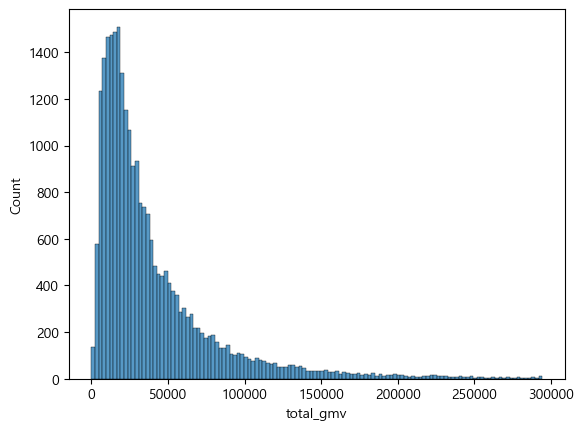

In [ ]:
sns.histplot(tt.total_gmv)
plt.show()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

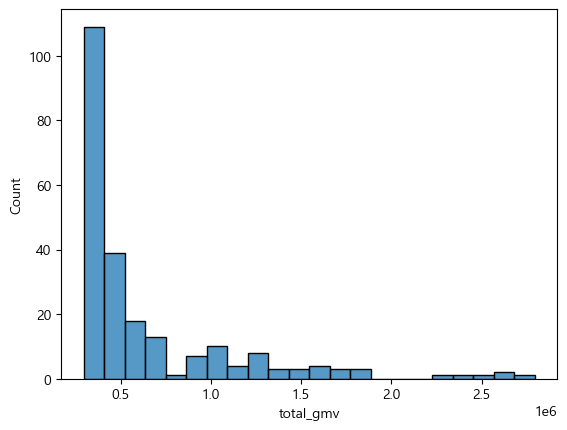

In [ ]:
sns.histplot(ss.total_gmv)
plt.plot()

In [ ]:
tt.describe()


,total_gmv,total_commission,total_quantity,orderDate,zscore
count,25749.000000,25749.000000,25749.000000,25749.000000,25749.000000
mean,40024.954018,2040.160045,3.509496,2.854790,-0.063990
std,40812.439372,2084.610794,3.990497,2.962652,0.490787
min,2.000000,1.000000,0.000000,1.000000,-0.545283
25%,14700.000000,736.000000,1.000000,1.000000,-0.368533
50%,26410.000000,1344.000000,2.000000,2.000000,-0.227716
75%,50010.000000,2555.000000,4.000000,3.000000,0.056084
max,294270.000000,15454.000000,65.000000,53.000000,2.993413


In [ ]:
ss.describe()

,total_gmv,total_commission,total_quantity,orderDate,zscore
count,2.310000e+02,231.000000,231.000000,231.000000,231.000000
mean,6.384912e+05,29698.367965,13.476190,10.108225,7.132816
std,4.879761e+05,23605.243142,17.761906,12.991016,5.868117
min,2.949600e+05,6777.000000,1.000000,1.000000,3.001710
25%,3.389150e+05,16879.000000,2.000000,2.000000,3.530287
50%,4.327800e+05,20723.000000,5.000000,5.000000,4.659053
75%,6.972700e+05,31306.500000,20.500000,14.000000,7.839656
max,2.794200e+06,146696.000000,143.000000,103.000000,33.056114


- 구간화
    - 95%, 2만원단위. 5% 초고액

In [33]:
tt.total_gmv.max()

128500.0

In [12]:
# 구간 범위 설정 (5만원 단위)
bins = np.arange(0, tt['total_gmv'].max() + 20000, 20000)  # 최대값보다 하나 더 많은 구간을 포함하기 위해 추가

# pd.cut을 사용하여 매출 데이터를 구간별로 나누기
labels = [f'{int(i)}원 - {int(j)}원' for i, j in zip(bins[:-1], bins[1:])]  # 레이블 생성
tt['range'] = pd.cut(tt['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기 Normal
ss['range'] = pd.cut(ss['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기 Normal

df = pd.concat([tt,ss],axis=0)
df.range.cat.categories
df['range'] = df['range'].cat.add_categories('140000원 이상')
df['range'].fillna('140000원 이상', inplace=True)

In [14]:
df.groupby('range')[['subParam']].count()['subParam'].sum()

25980

In [95]:
df.groupby('range')[['total_gmv']].mean()

,total_gmv
range,
0원 - 20000원,11972.342739
20000원 - 40000원,28821.224407
40000원 - 60000원,49191.973981
60000원 - 80000원,69078.940737
80000원 - 100000원,89174.967402
100000원 - 120000원,109503.432473
120000원 - 140000원,129858.281532
140000원 이상,279614.252823


In [97]:
df.to_parquet('../result/grp_0403_0509.parquet')

## 행동 데이터와 머지

1. 동 기간동안 유저아이디별 집계된 행동 정보 Merge
2. 매출과의 회귀분석 실행
3. 장바구니 분석
4. 특히, 챌린지 및 earn 금액과 구매간의 상관성 확인

In [7]:
from google.cloud import bigquery
from google.cloud.bigquery import job

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

# 클라이언트 설정
client = bigquery.Client()

# SQL 파일 읽기
file = '../query/0515_행동데이터.sql'
with open(file, 'r') as file:
    query = file.read()


In [8]:
job_config = bigquery.QueryJobConfig()
query_job = client.query(query, job_config=job_config)

df = query_job.to_dataframe()

In [11]:
df[df['total_visits']==0].describe()




,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits
count,47110.0,47110.0,47110.000000,47110.000000,47110.000000,47110.0,47110.000000,47110.000000,47110.000000,47110.0,47110.0,47110.0,47110.0,47110.0
mean,0.057758,0.014434,33.032774,0.163872,10.425876,0.090596,59.796222,0.003885,0.257758,0.000085,0.530354,1.339312,0.0,0.0
std,0.310502,0.223831,55.177824,1.355326,77.323828,0.607001,388.125176,0.133078,35.972906,0.011285,1.953481,2.297823,0.0,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,15.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0
75%,0.0,0.0,46.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0
max,7.0,21.0,589.000000,30.000000,3961.000000,43.0,16000.000000,10.000000,6429.000000,2.0,90.0,61.0,0.0,0.0
